# Tree shape diversity

### The plot elements below will be saved to `/analysis/output/NDS-LB/`

In [1]:
import glob
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize, SymLogNorm

## Load GC trees and constuct a data frame of statistics

In [2]:
results = "../nextflow/results/latest"

In [3]:
def gc_key(file):
    PR_str = file.split("/")[-2].split("-")
    return int(PR_str[1]), f"{PR_str[3]}-{PR_str[2]}"

files = sorted(glob.glob(f"{results}/gctrees/PR*/gctree.p"), key=gc_key)
trees = {"_".join(f"{x}{y}" for x, y in zip(("mouse", "GC"), gc_key(file))): pickle.load(open(file, "rb"))
         for file in files}

print(f"loaded {len(trees)} GC trees")

loaded 95 GC trees


In [4]:
df = pd.DataFrame()

for row, (mouse_gc, tree) in enumerate(trees.items()):
    mouse, gc = mouse_gc.split("_")
    mouse = mouse.lstrip("mouse")
    
    # polytomy degree as simple branching metric
    # Duncan's local branching fraction (LBF)
    total_length = sum(node.dist for node in tree.tree.traverse())
    for node in tree.tree.traverse():
        node.add_feature("log10_polytomy_degree", np.log10(len(node.children) + node.abundance))
        node.add_feature("LBF", sum(node.LB_down.values()) / total_length)
    
    if mouse in ("7", "8"):
        df.loc[row, "mouse type"] = "10-weeks"
    elif mouse in ("9", "10", "11", "12"):
        df.loc[row, "mouse type"] = "LMP"
    else:
        df.loc[row, "mouse type"] = "20 days"
    
    gc = gc.lstrip("GC")
    df.loc[row, "mouse"] = mouse
    df.loc[row, "germinal center"] = gc
    
    abundances = np.array([node.abundance for node in tree.tree.traverse()])

    if len(tree.tree.children) == 1:
        root = tree.tree.children[0]
    else:
        root = tree.tree
    clade_sizes = [sum(node.abundance for node in child.traverse()) for child in root.children]
    df.loc[row, "cells sampled"] = sum(abundances)
    df.loc[row, "normalized dominance score"] = max(clade_sizes) / sum(clade_sizes)
    df.loc[row, "maximum local branching ratio"] = np.nanmax([node.LBR for node in tree.tree.traverse()])    
    
    # note: additive delta_bind for now
    delta_bind_dat = []
    for node in tree.tree.traverse():
        if not np.isnan(node.delta_bind_CGG_FVS_additive):
            for _ in range(node.abundance):
                delta_bind_dat.append(node.delta_bind_CGG_FVS_additive)
    df.loc[row, "95th percentile affinity increase"] = np.percentile(delta_bind_dat, 95)
    df.loc[row, "median affinity increase"] = np.nanmedian(delta_bind_dat)
    df.loc[row, "maximum affinity increase"] = np.nanmax(delta_bind_dat)

    max_lbr_idx = np.nanargmax([node.LBR for node in tree.tree.traverse()])
    df.loc[row, "affinity increase of max LBR node"] = [node.delta_bind_CGG_FVS_additive for node in tree.tree.traverse()][max_lbr_idx]

# only 20-day mice    
df_20 = df.loc[df["mouse type"] == "20 days"]

df

,mouse type,mouse,germinal center,cells sampled,normalized dominance score,maximum local branching ratio,95th percentile affinity increase,median affinity increase,maximum affinity increase,affinity increase of max LBR node
0,20 days,1,1-RP,89.0,0.932584,10.383587,1.260416,1.124685,1.75955,0.00000
1,20 days,1,11-RB,66.0,0.742424,26.029871,1.294376,1.065520,1.87747,1.06552
2,20 days,1,12-RB,49.0,0.530612,9.870848,1.475176,1.102810,2.19856,1.47229
3,20 days,1,13-RB,88.0,0.306818,15.392165,2.034419,1.198050,2.34731,0.33100
4,20 days,1,14-RB,84.0,0.452381,8.136900,2.407759,0.825960,2.53366,0.00000
...,...,...,...,...,...,...,...,...,...,...
90,LMP,12,126-RB,72.0,0.500000,10.150551,1.850279,0.650005,2.24972,0.00000
91,LMP,12,127-RB,77.0,0.727273,7.556685,1.515848,0.843260,2.27841,-1.95048
92,LMP,12,128-LB,78.0,0.538462,8.334395,1.808886,1.132700,1.94741,0.00000
93,LMP,12,129-LB,75.0,0.800000,27.343157,1.792378,1.670790,1.91919,1.70948


In [5]:
output_dir = "output/NDS-LB"

In [6]:
df.to_csv(f"{output_dir}/data.csv")

## Rank plot of total GC cell abundance 

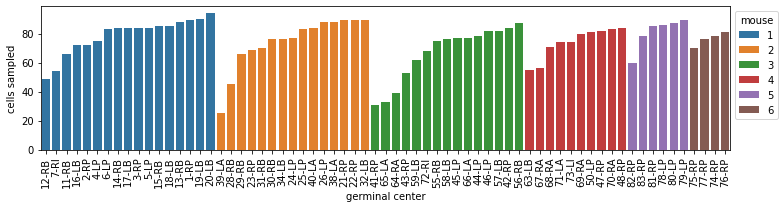

In [7]:
plt.figure(figsize=(11, 3))
ax = sns.barplot(data=df_20.sort_values(["mouse", "cells sampled"]), x="germinal center", y="cells sampled", hue="mouse", dodge=False)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig(f"{output_dir}/abundances.pdf")
plt.show()

## Plot tree shape stats in a scatter plot, and render some example trees
For each tree we render it colored by LBR, then by affinity

mouse1, GC4-LP


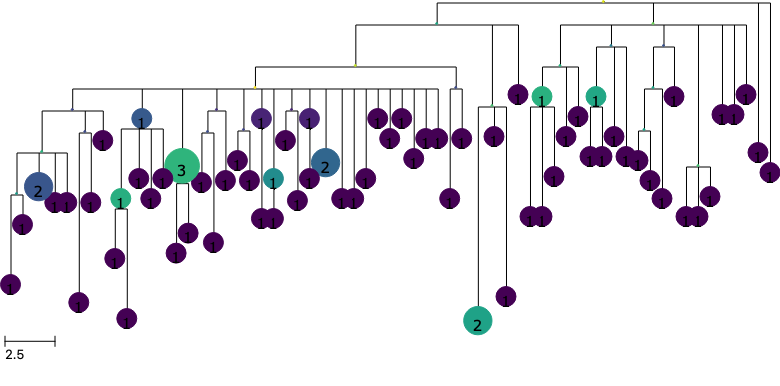

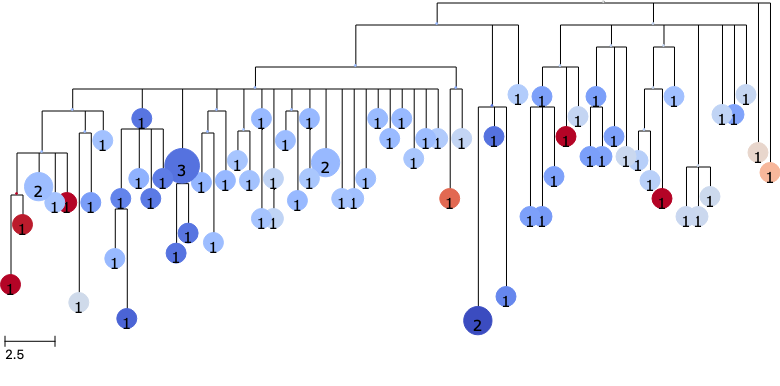

mouse2, GC28-RB


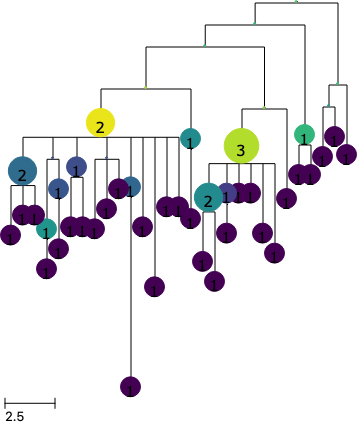

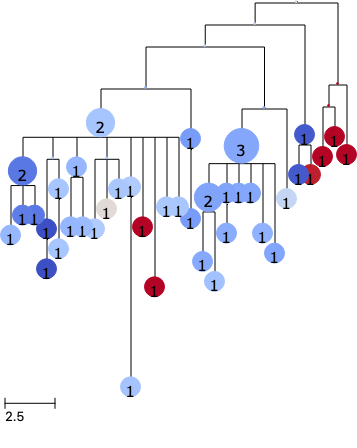

mouse2, GC34-LB


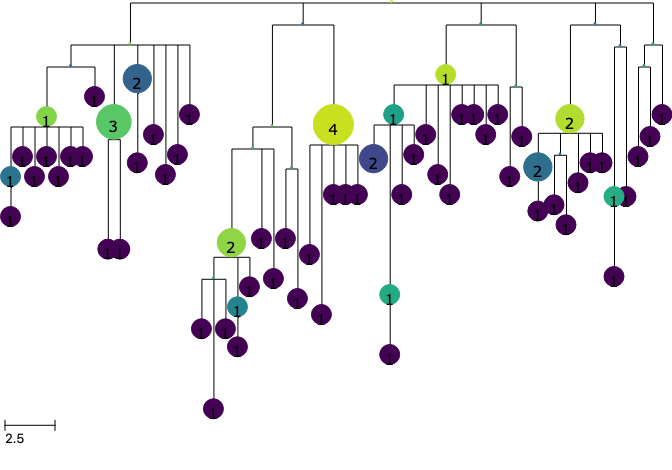

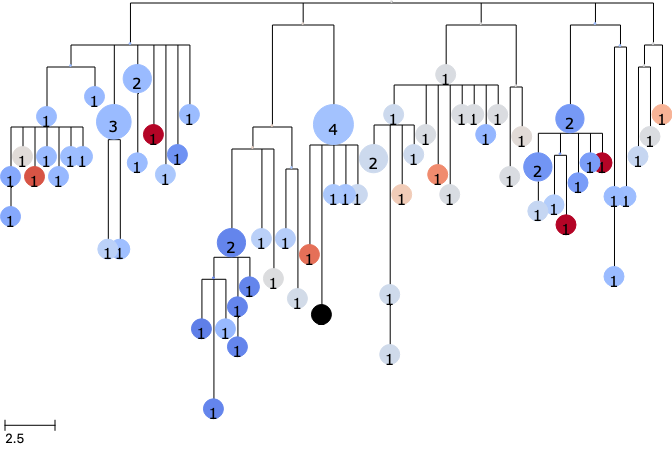

mouse4, GC50-LP


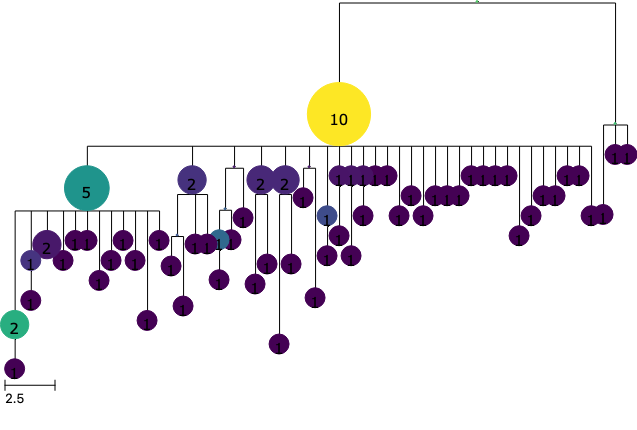

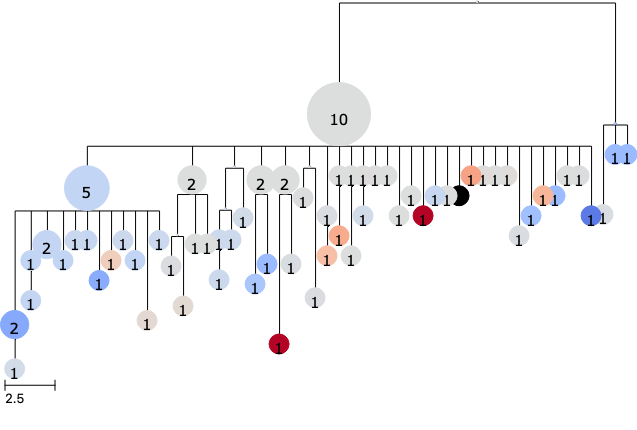

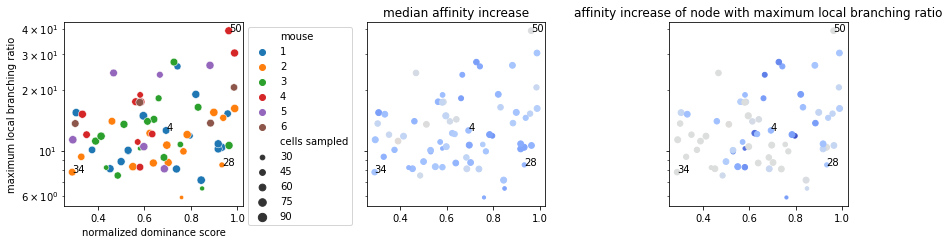

In [8]:
# LBR cmap
cmap = "viridis"
vmin = 0
vmax = 10

# affinity cmap
cmap2 = "coolwarm_r"
vmin2 = -2
vmax2 = 2

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 3.5), sharey=True)
sns.scatterplot(data=df_20, x="normalized dominance score", y="maximum local branching ratio", hue="mouse", size="cells sampled",
                clip_on=False, ax=ax1)
sns.move_legend(ax1, "upper left", bbox_to_anchor=(1, 1))
ax2.set_title("median affinity increase")
ax2.scatter(df_20["normalized dominance score"], df_20["maximum local branching ratio"], c=df_20["median affinity increase"], s=0.4 * df_20["cells sampled"],
                clip_on=False,
                cmap=cmap2, vmin=vmin2, vmax=vmax2)
ax3.set_title("affinity increase of node with maximum local branching ratio")
ax3.scatter(df_20["normalized dominance score"], df_20["maximum local branching ratio"], c=df_20["affinity increase of max LBR node"], s=0.4 * df_20["cells sampled"],
                clip_on=False,
                cmap=cmap2, vmin=vmin2, vmax=vmax2)
ax1.set_yscale("log")
ax2.set_yscale("log")
ax3.set_yscale("log")
for i, row in df_20.iterrows():
    x, y = row[["normalized dominance score", "maximum local branching ratio"]]
    if (x > 0.9 and y > 31) or (x < 0.4 and y < 8) or ((.65 < x < .75) and (11 < y < 13)) or (x > 0.9 and y < 9):
        print(f"mouse{row.mouse}, GC{row['germinal center']}")
        ax1.annotate(f"{row['germinal center'][:-3]}", [x, y])
        ax2.annotate(f"{row['germinal center'][:-3]}", [x, y])
        ax3.annotate(f"{row['germinal center'][:-3]}", [x, y])
        key = f"mouse{row.mouse}_GC{row['germinal center']}"
        colormap = trees[key].feature_colormap("LBR", vmin=vmin, vmax=vmax, scale="symlog", linthresh=1, cmap=cmap)
        trees[key].render(f"{output_dir}/{key}.LBR.svg", colormap=colormap, scale=20, branch_margin=-8)
        display(trees[key].render("%%inline", colormap=colormap, scale=20, branch_margin=-8))
        colormap = trees[key].feature_colormap("delta_bind_CGG_FVS_additive", vmin=vmin2, vmax=vmax2, cmap=cmap2)
        trees[key].render(f"{output_dir}/{key}.binding.svg", colormap=colormap, scale=20, branch_margin=-8)
        display(trees[key].render("%%inline", colormap=colormap, scale=20, branch_margin=-8))
plt.tight_layout()
plt.savefig(f"{output_dir}/scatter.pdf")
plt.show()

## Color bars for the two tree colormaps

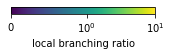

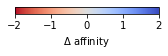

In [9]:
fig = plt.figure(figsize=(2, 1))
cax = fig.add_axes([0, 0, 1, 0.1])
plt.colorbar(cm.ScalarMappable(cmap=cmap, norm=SymLogNorm(linthresh=1, vmin=vmin, vmax=vmax)),
             orientation='horizontal',
             cax=cax,
             label="local branching ratio")
plt.savefig(f"{output_dir}/cbar1.pdf", bbox_inches="tight")
plt.show()

fig = plt.figure(figsize=(2, 1))
cax = fig.add_axes([0, 0, 1, 0.1])
plt.colorbar(cm.ScalarMappable(cmap=cmap2, norm=Normalize(vmin=vmin2, vmax=vmax2)),
             orientation='horizontal',
             cax=cax,
             label=r"$\Delta$ affinity")
plt.savefig(f"{output_dir}/cbar2.pdf", bbox_inches="tight")
plt.show()